## Wine Quality Analysis & Score Prediction
Identifying what contributes to a good wine and developing a predictive model for wine quality scoring

### 1. Setup - install & import standard packages

In [1]:
# pip install scikit-learn
# pip install statsmodels
# pip install shap
# pip install ipywidgets
# jupyter nbextension enable --py widgetsnbextension

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### 2. Load data & show overview

In [3]:
df=pd.read_csv("C:/Users/username/Documents/Python/winequality-red.csv")

In [4]:
print(df.describe) # combines df.head(5), df_tail(5) and df.shape

<bound method NDFrame.describe of       fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0               7.4             0.700         0.00             1.9      0.076   
1               7.8             0.880         0.00             2.6      0.098   
2               7.8             0.760         0.04             2.3      0.092   
3              11.2             0.280         0.56             1.9      0.075   
4               7.4             0.700         0.00             1.9      0.076   
...             ...               ...          ...             ...        ...   
1594            6.2             0.600         0.08             2.0      0.090   
1595            5.9             0.550         0.10             2.2      0.062   
1596            6.3             0.510         0.13             2.3      0.076   
1597            5.9             0.645         0.12             2.0      0.075   
1598            6.0             0.310         0.47             3.6      0.0

### 3. Data pre-processing

#### Create a copy

In [5]:
df2=df.copy()

#### Rename columns

In [8]:
df2.rename(columns={'<bound method NDFrame.describe of':'index','Overall rank': 'Rank', 'Country or region':'Country',"GDP per capita":"GDP/capita",'Healthy life expectancy':'Healthy life exp','Freedom to make life choices':'Freedom','Perceptions of corruption':'Corruption exp'}, inplace=True)
print(df2.head(5))

   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   

   alcohol  quality  
0      9.4        5  
1      9.8        5  
2      9.8        5 

#### Check absence of missing values

In [9]:
print(df2.isnull().sum(axis=0).sum())

0


#### Scale data

In [32]:
# option 1: for loop and mathematical normalization
for col in df2.columns:
    df2[col] = df2[col]-df2[col].min()
    df2[col] = df2[col]/df2[col].max()
print(df2.head(5))

# option 2: more concisely using pandas, column by column
df2 = (df2 - df2.min()) / (df2.max() - df2.min())
print(df2.head(5))

   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0       0.247788          0.397260         0.00        0.068493   0.106845   
1       0.283186          0.520548         0.00        0.116438   0.143573   
2       0.283186          0.438356         0.04        0.095890   0.133556   
3       0.584071          0.109589         0.56        0.068493   0.105175   
4       0.247788          0.397260         0.00        0.068493   0.106845   

   free sulfur dioxide  total sulfur dioxide   density        pH  sulphates  \
0             0.140845              0.098940  0.567548  0.606299   0.137725   
1             0.338028              0.215548  0.494126  0.362205   0.209581   
2             0.197183              0.169611  0.508811  0.409449   0.191617   
3             0.225352              0.190813  0.582232  0.330709   0.149701   
4             0.140845              0.098940  0.567548  0.606299   0.137725   

    alcohol  quality  
0  0.153846      0.4  
1  0.21538

#### Split data into train-test sets

goals:
- create x_train, y_train (float, continuous), yc_train (categorical), x_test, y_test (float, continuous), yc_test (categorical), with y's being Series
- create df2_train as easier to use in exploratory data analysis

In [13]:
# (optional) randomize rows before training/test set split (to be sure)
print("--- original dataset ---")
print(df2.head())
print("--- preliminary random permutation ---")
df2 = df2.iloc[np.random.permutation(len(df2)),:].reset_index(drop=True) # use numpy's random permutation function + reset index
print(df2.head())
print(df2.shape)

# option 1: function and explicit training/test set split, with y as a Series
def split_dataset(df_in, training_set_perc:float):
    nb_rows_train:int = int(round(training_set_perc/100*df_in.shape[0],0)) # could be directly set in two formulas below
    df_train = df_in.iloc[0:nb_rows_train,:] # to and excl. nb_rows_train
    df_test = df_in.iloc[nb_rows_train:,:]
    x_train = df_train.iloc[:,:-1]
    y_train = pd.Series(df_train.iloc[:,-1])
    yc_train = pd.Series(pd.Categorical(df_train.iloc[:,-1], ordered=True))
    x_test = df_test.iloc[:,:-1]
    y_test = pd.Series(df_test.iloc[:,-1])
    yc_test = pd.Series(pd.Categorical(df_test.iloc[:,-1], ordered=True))

    return x_train, y_train, yc_train, x_test, y_test, yc_test

training_set_percent:float = 70.0
(x_train,y_train,yc_train,x_test,y_test,yc_test) = split_dataset(df2,training_set_percent)
print("--- train/test split - custom function ---")
print(x_train.shape)
print(y_train.shape)
print(yc_train.shape)
print(x_test.shape)
print(y_test.shape)
print(yc_test.shape)

print(y_train.dtype)
print(yc_train.dtype)

# option 2: built-in function (sklearn) while keeping y variables as dataframes
import sklearn.model_selection as mds(x_train, x_test, y_train, y_test) = mds.train_test_split(df2.iloc[:,:-1], df2.iloc[:,-1], train_size=training_set_percent/100, random_state=35)
yc_train = pd.Categorical(y_train, ordered=True)
yc_test = pd.Categorical(y_test, ordered=True)
print("--- train/test split - sklearn - train_test_split ---")
print(x_train.shape)
print(y_train.shape)
print(yc_train.shape)
print(x_test.shape)
print(y_test.shape)
print(yc_test.shape)

# option 3 (preferred): built-in function (scikit-learn) with stratification while keeping y variables as dataframes
(x_train, x_test, y_train, y_test) = mds.train_test_split(df2.iloc[:,:-1], df2.iloc[:,-1], train_size=training_set_percent/100, stratify=df2.iloc[:,-1])
yc_train = pd.Categorical(y_train, ordered=True)
yc_test = pd.Categorical(y_test, ordered=True)
print("--- train/test split - sklearn - train_test_split with stratification ---")
print(x_train.shape)
print(y_train.shape)
print(yc_train.shape)
print(x_test.shape)
print(y_test.shape)
print(yc_test.shape)

--- original dataset ---
   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0       0.318584          0.184932         0.38        0.041096   0.076795   
1       0.176991          0.315068         0.02        0.102740   0.095159   
2       0.327434          0.335616         0.30        0.082192   0.120200   
3       0.345133          0.191781         0.40        0.369863   0.063439   
4       0.619469          0.205479         0.53        0.164384   0.155259   

   free sulfur dioxide  total sulfur dioxide   density        pH  sulphates  \
0             0.126761              0.081272  0.450073  0.409449   0.245509   
1             0.253521              0.120141  0.279001  0.503937   0.197605   
2             0.140845              0.155477  0.523495  0.519685   0.167665   
3             0.028169              0.014134  0.410426  0.425197   0.137725   
4             0.450704              0.325088  0.802496  0.362205   0.371257   

    alcohol  quality  
0  0.215

In [14]:
# create df2_train_set for exploratory analysis
df2_train = pd.concat([x_train,y_train],axis=1)
print(df2_train.shape)

(1119, 12)


### 4. Exploratory data analysis (training set)

Nb: data visualization made on training set only to avoid any bias from using the test set

#### Summary statistics

In [15]:
print(df2_train.describe()) # combines df.head(5), df_tail(5) and df.shape

       fixed acidity  volatile acidity  citric acid  residual sugar  \
count    1119.000000       1119.000000  1119.000000     1119.000000   
mean        0.327204          0.278006     0.272029        0.113641   
std         0.152541          0.123622     0.192013        0.099465   
min         0.000000          0.000000     0.000000        0.000000   
25%         0.221239          0.184932     0.100000        0.068493   
50%         0.292035          0.273973     0.260000        0.089041   
75%         0.398230          0.356164     0.430000        0.116438   
max         1.000000          0.828767     0.790000        1.000000   

         chlorides  free sulfur dioxide  total sulfur dioxide      density  \
count  1119.000000          1119.000000           1119.000000  1119.000000   
mean      0.122288             0.207120              0.143277     0.484975   
std       0.067358             0.141626              0.119085     0.137533   
min       0.000000             0.000000         

#### Histograms - per feature

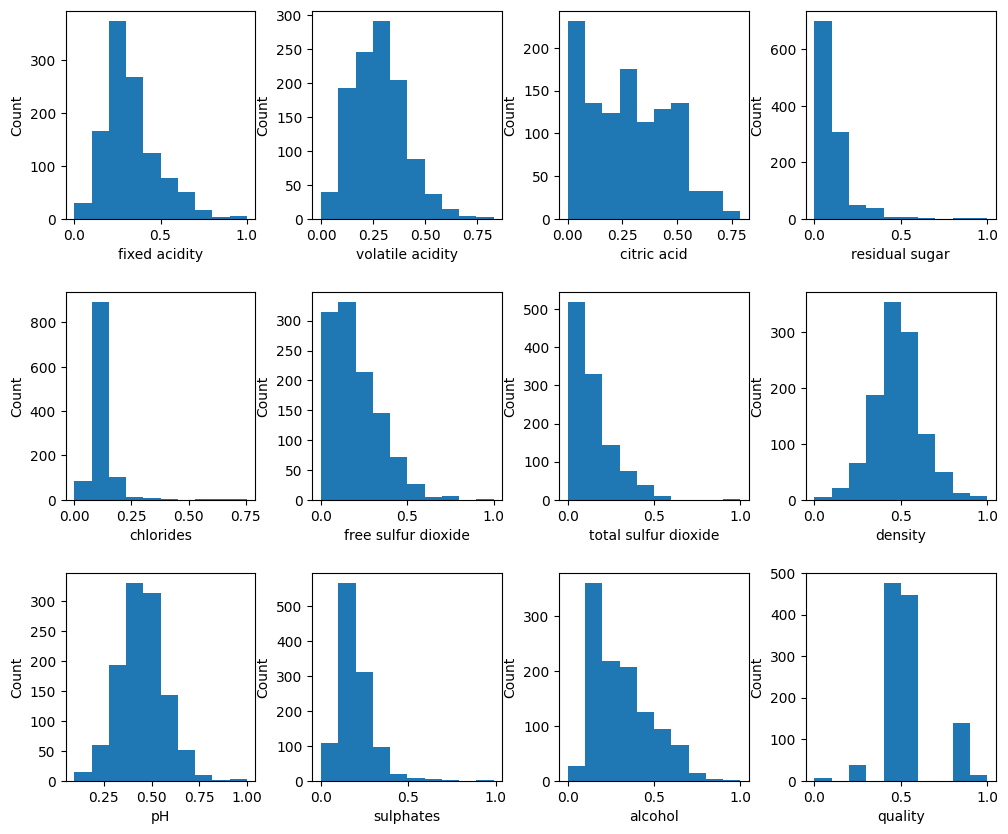

In [18]:
# define subplot axes objects e.g. using Matplotlib
fig, axes = plt.subplots(3,4,figsize=(12, 10))
fig.subplots_adjust(wspace=0.3, hspace=0.35) # increase space between subplots (after first attempts) for better readability

# for loop over the columns/explanatory variables and apply a histogram plot on them using Pandas
for i, col in enumerate(df2_train.columns.values):  # use enumerate to generate both the column label and an index for the subplot
    df2_train.loc[:,col].plot(x=col, kind="hist", ax=axes.flatten()[i], xlabel=col, ylabel='Count')
plt.show()

Observations (wine quality)
- most tested wines are average
- very limited number (proportionally) of good/bad wines, which might considerably affect the quality of any classifier
- modeling wine quality and differentiating good/bad wines might require to discard average wines (to be assessed by data scientist)

Observations (explanatory variables)
- explanatory variables don't show any multimodality
- pH and density are likely normally distributed
- all other variables show a skewed distribution

#### Scatter plots - per feature

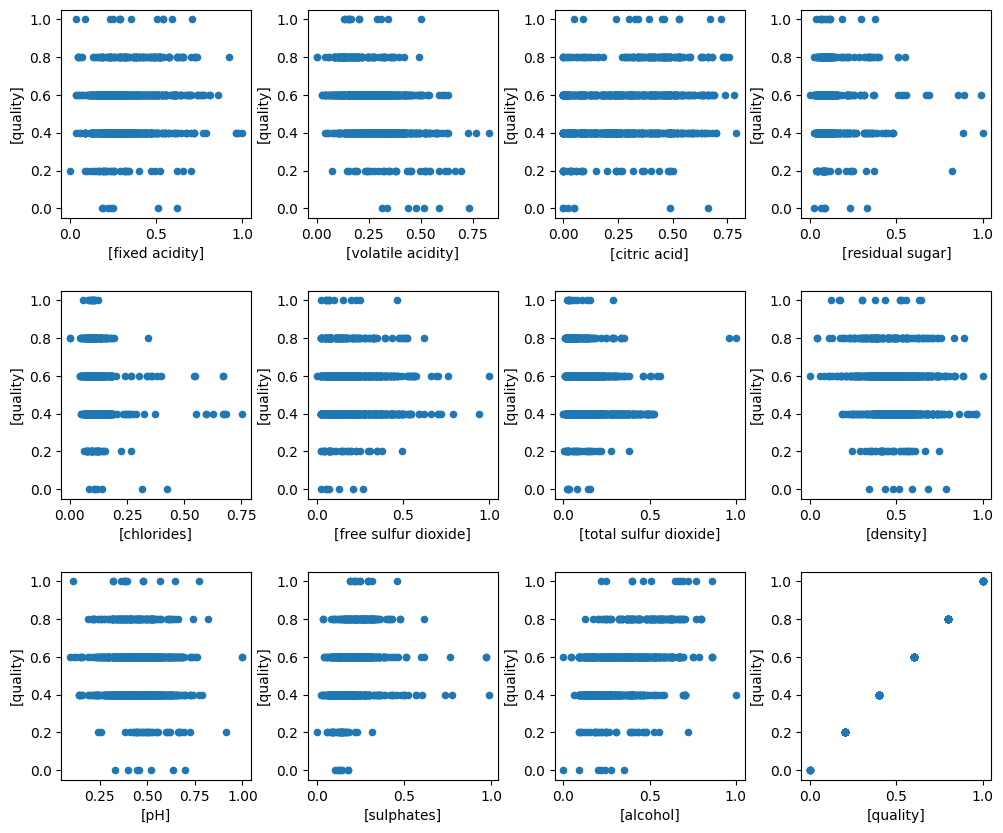

In [19]:
# define subplot axes objects e.g. using Matplotlib
fig, axes = plt.subplots(3,4,figsize=(12, 10))
fig.subplots_adjust(wspace=0.3, hspace=0.35) # increase space between subplots (after first attempts) for better readability

# for loop over the columns/explanatory variables and apply a scatter plot on them (versus Score) using Pandas
for i, col in enumerate(df2_train.columns.values):  # use enumerate to generate both the column label and an index for the subplot
    df2_train.plot(x=[col], y=["quality"], kind="scatter", ax=axes.flatten()[i]) # flatten axes is key here to facilitate indexing
plt.show()

Observations:
- difficult to see any type of relationship between y and x's, due to the discrete nature of the wine quality variable
- no variable seem to show obvious outliers, except maybe total sulfur dioxide and citric acid for one data point each (no treatment); data quality can be confirmed on the test set as well

#### Box plots - per feature

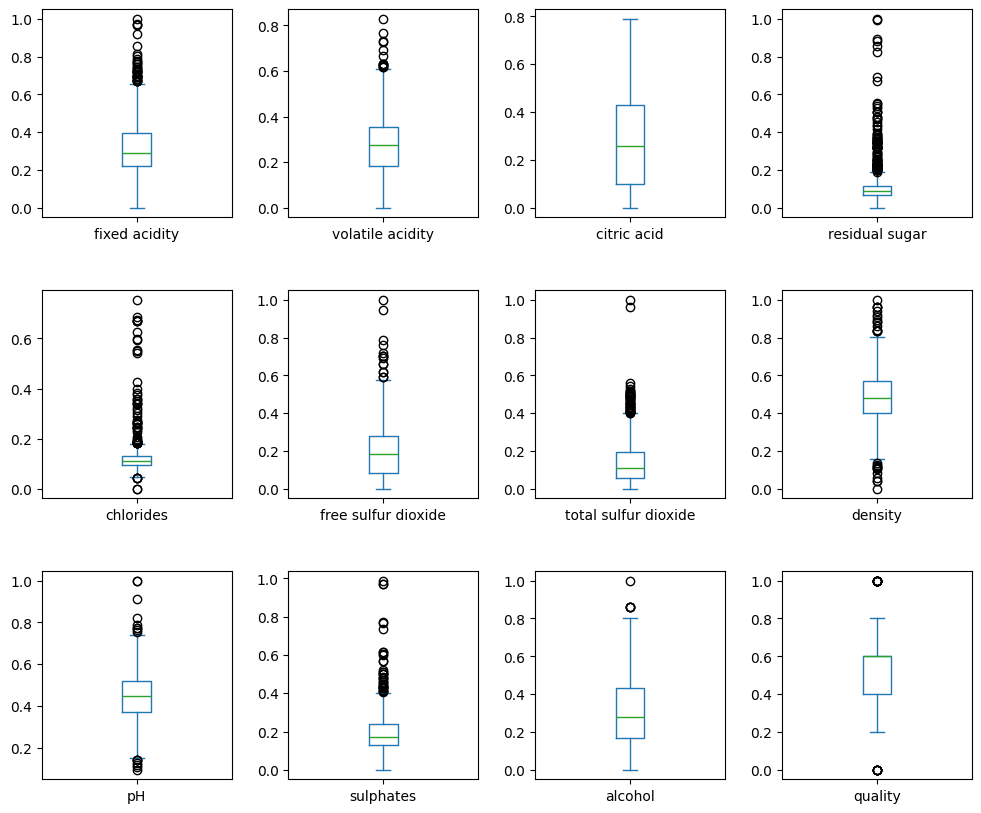

In [20]:
# define subplot axes objects e.g. using Matplotlib
fig, axes = plt.subplots(3,4,figsize=(12, 10))
fig.subplots_adjust(wspace=0.3, hspace=0.35) # increase space between subplots (after first attempts) for better readability

# for loop over the columns/explanatory variables and apply a box plot on them using Pandas
for i, col in enumerate(df2_train.columns.values):  # use enumerate to generate both the column label and an index for the subplot
    df2_train.loc[:,col].plot(x=col, kind="box", ax=axes.flatten()[i])
plt.show()

#### (Correlation matrix - Pearson & Spearman)

In [21]:
# Pearson's linear correlation
df2_train.corr(method='pearson')

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
fixed acidity,1.000000,-0.262731,0.662622,0.112072,0.121573,-0.170351,-0.120746,0.662880,-0.682255,0.216451,-0.026615,0.143652
volatile acidity,-0.262731,1.000000,-0.560995,-0.016762,0.060064,0.017807,0.085432,0.018537,0.239184,-0.292016,-0.213325,-0.394106
citric acid,0.662622,-0.560995,1.000000,0.146595,0.165735,-0.077229,0.047592,0.351752,-0.522825,0.313713,0.136332,0.257262
residual sugar,0.112072,-0.016762,0.146595,1.000000,0.028442,0.166182,0.202688,0.335786,-0.084187,0.003012,0.077405,0.031291
chlorides,0.121573,0.060064,0.165735,0.028442,1.000000,-0.001488,0.038086,0.230985,-0.237272,0.276904,-0.229052,-0.125162
free sulfur dioxide,-0.170351,0.017807,-0.077229,0.166182,-0.001488,1.000000,0.659242,-0.035035,0.089408,0.040936,-0.061739,-0.067749
total sulfur dioxide,-0.120746,0.085432,0.047592,0.202688,0.038086,0.659242,1.000000,0.062383,-0.070226,0.031356,-0.192980,-0.193781
density,0.662880,0.018537,0.351752,0.335786,0.230985,-0.035035,0.062383,1.000000,-0.342704,0.163559,-0.477827,-0.167582
pH,-0.682255,0.239184,-0.522825,-0.084187,-0.237272,0.089408,-0.070226,-0.342704,1.000000,-0.195243,0.184401,-0.080475
sulphates,0.216451,-0.292016,0.313713,0.003012,0.276904,0.040936,0.031356,0.163559,-0.195243,1.000000,0.116832,0.289514


In [22]:
# Spearman's rank correlation
df2_train.corr(method='spearman')

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
fixed acidity,1.000000,-0.279142,0.653334,0.228210,0.242449,-0.195963,-0.109902,0.621158,-0.706790,0.240510,-0.048169,0.135605
volatile acidity,-0.279142,1.000000,-0.612709,0.026047,0.163711,0.050592,0.101900,0.024086,0.233839,-0.348561,-0.228693,-0.391945
citric acid,0.653334,-0.612709,1.000000,0.164554,0.091229,-0.098029,0.000443,0.341217,-0.533190,0.348615,0.114808,0.242309
residual sugar,0.228210,0.026047,0.164554,1.000000,0.191908,0.077166,0.136798,0.411326,-0.090917,0.065011,0.148130,0.059833
chlorides,0.242449,0.163711,0.091229,0.191908,1.000000,0.027280,0.141163,0.420602,-0.209667,0.017099,-0.301371,-0.198311
free sulfur dioxide,-0.195963,0.050592,-0.098029,0.077166,0.027280,1.000000,0.786890,-0.061865,0.136860,0.017324,-0.077000,-0.078911
total sulfur dioxide,-0.109902,0.101900,0.000443,0.136798,0.141163,0.786890,1.000000,0.113082,0.003575,-0.025276,-0.250770,-0.223126
density,0.621158,0.024086,0.341217,0.411326,0.420602,-0.061865,0.113082,1.000000,-0.314792,0.168652,-0.464510,-0.166273
pH,-0.706790,0.233839,-0.533190,-0.090917,-0.209667,0.136860,0.003575,-0.314792,1.000000,-0.078226,0.158522,-0.063421
sulphates,0.240510,-0.348561,0.348615,0.065011,0.017099,0.017324,-0.025276,0.168652,-0.078226,1.000000,0.229444,0.395950


Observation: no strong linear correlation with wine quality here, just a moderate one from alcohol

#### Histograms - per feature with 0.2/0.8 quality score thresholds split

The idea is to focus on what matters, the very good/bad wines, and efficiently see how they differ

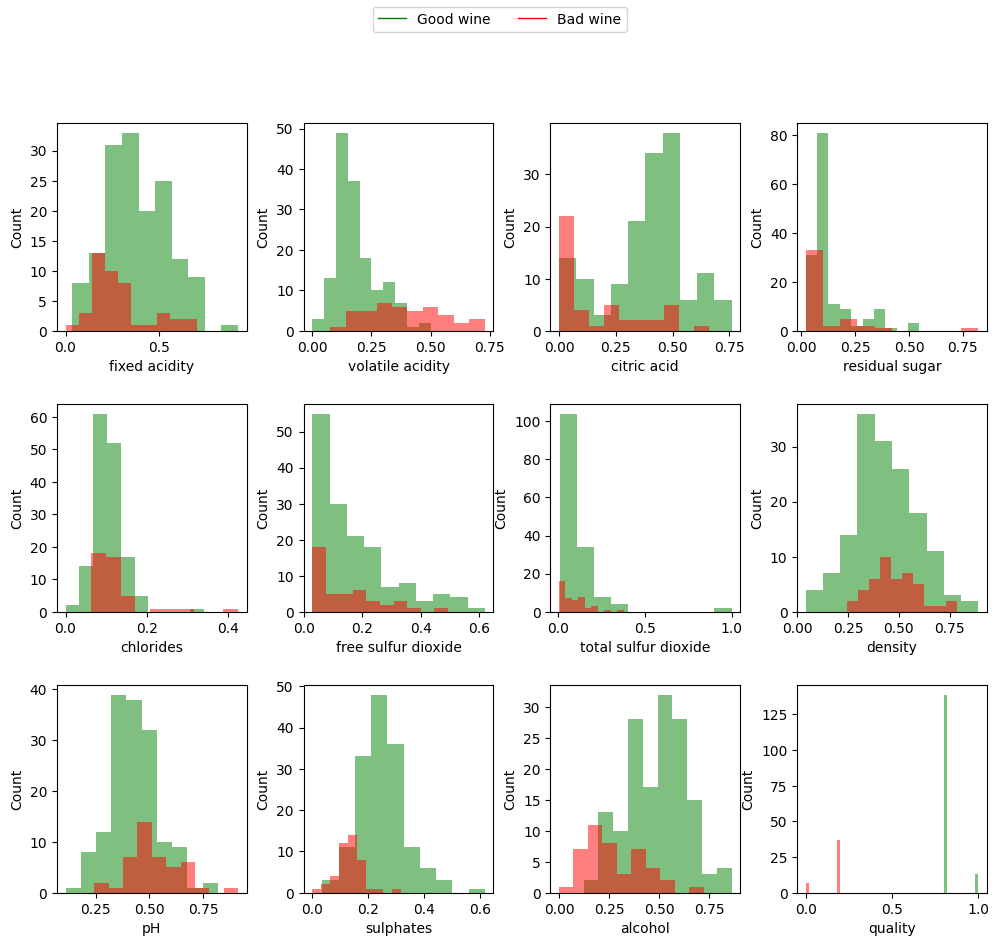

In [24]:
# define subplot axes objects e.g. using Matplotlib
fig, axes = plt.subplots(3,4,figsize=(12, 10))
fig.subplots_adjust(wspace=0.3, hspace=0.35) # increase space between subplots (after first attempts) for better readability
# for loop over the columns/explanatory variables and apply a histogram plot on them using Pandas
for i, col in enumerate(df2_train.columns.values):  # use enumerate to generate both the column label and an index for the subplot
    df2_train.loc[df2_train.loc[:,'quality']>=0.8,col].plot(x=col, kind="hist", ax=axes.flatten()[i], alpha = 0.5, color='g', xlabel=col, ylabel='Count')
    df2_train.loc[df2_train.loc[:,'quality']<=0.2,col].plot(x=col, kind="hist", ax=axes.flatten()[i], alpha = 0.5, color='r', xlabel=col, ylabel='Count')
fig.legend(handles=[plt.Line2D([0], [0], color='g', lw=1), plt.Line2D([0], [0], color='r', lw=1)], labels=['Good wine', 'Bad wine'], loc='upper center', ncol=2)
plt.show()

Factors that might explain very good wine quality
- +quite higher fixed acidity
- ++ much lower volatile acidity
- +more citric acid
- slightly more residual sugar
- possibly less free sulfur dioxide
- low total sulfur dioxide

- slightly more sulphates
- ++ much more alcohol

Don't seem to have a significant effect (to be confirmed)
- chlorides
- density - not so clear
- pH, or maybe slightly lower can be better

#### Box plots - per feature and wine quality score

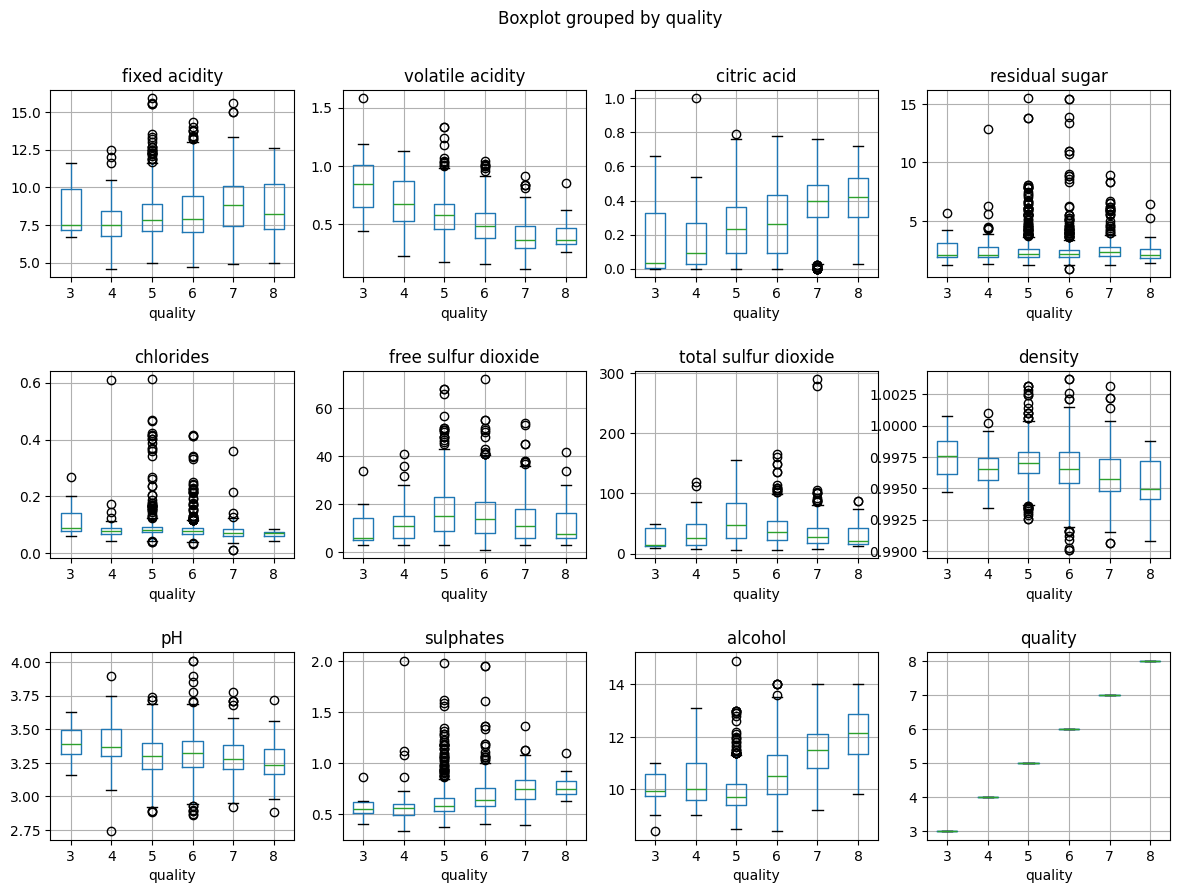

In [29]:
fig, axes = plt.subplots(3,4,figsize=(14, 10))
fig.subplots_adjust(wspace=1.0, hspace=0.5) # increase space between subplots (after first attempts) for better readability
axes=axes.flatten() # easier syntax below
for i, col in enumerate(df2_train.columns.values):
    df.boxplot(column=col, by='quality', ax=axes[i])
    axes[i].set_title(col)
    axes[i].set_xlabel("quality")
    #axes[i].set_ylabel(col)
plt.show()

# next: could remove the last chart (nice to have)
# next: further increase horizontal space to show a y axis but it doesn't work even after several attempts => yaxis label replaced by subplot title

Observations: better wines seem to show
- higher average fixed acidity but might not be significative
- ++ clearly lower volatile acidity
- ++ clearly more citric acid
- +lower density
- a slightly lower pH on average
- +more sulphates
- ++ clearly more alcohol

#### Mutual information

In [25]:
import sklearn.feature_selection as fs
mi = fs.mutual_info_regression(x_train, y_train, random_state=35)

mi_series = pd.Series(mi, index=x_train.columns).sort_values(ascending=False)

print("mutual information ranking:")
print(mi_series)

mutual information ranking:
alcohol                 0.185407
citric acid             0.112270
density                 0.096456
volatile acidity        0.093383
sulphates               0.086777
total sulfur dioxide    0.079790
fixed acidity           0.070251
chlorides               0.058493
free sulfur dioxide     0.032952
residual sugar          0.027183
pH                      0.010884
dtype: float64


Observations
- MI ranking confirms observations made above with box plots per wine quality score

### 5. Predictive regression model

#### Dimension reduction - variance inflation analysis

In [26]:
import statsmodels.stats.outliers_influence as oi

# compute VIF for each column
vif_df = pd.DataFrame()
vif_df["Feature"] = x_train.columns
vif_df["VIF"] = [oi.variance_inflation_factor(x_train.values, i) for i in range(x_train.shape[1])]

vif_df = vif_df.sort_values(by="VIF", ascending=False)

print("\n🔹 VIF values (higher = redundant):\n")
print(vif_df)


🔹 VIF values (higher = redundant):

                 Feature        VIF
7                density  82.432416
0          fixed acidity  39.043781
8                     pH  31.313325
10               alcohol  13.577963
1       volatile acidity  10.059411
2            citric acid   8.841771
9              sulphates   6.313347
5    free sulfur dioxide   6.052957
4              chlorides   5.280665
6   total sulfur dioxide   5.221697
3         residual sugar   3.892654


Observation and comments (methodo)
- some of the factors with high explanatory power identified here above also seem to show high VIF values, i.e. a high redundancy with other variables (correlated features, which was not necessarily apparent in the linear or rank correlation matrices
- this point should be kept in mind, as a predictive model might be sensitive to such correlated/redundant features
- if sensitive (e.g. linear models, for which coefs could be unstable/not reliable for interpretations), a proper filtering of variables should be done; or the model should be robust to it
- uninformative and redundant variables can still be discarded if wished, in a second simulation, depending on the model

#### Random forest regression

In [27]:
from sklearn.ensemble import RandomForestRegressor # easier to import specific functions
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# calibrate model + prediction for y_test
rfr = RandomForestRegressor(n_estimators=500, random_state=35, max_depth=None, n_jobs=-1)
rfr.fit(x_train, y_train)
y_test_pred = rfr.predict(x_test)

print("regression metrics:")
print("RMSE:", mean_squared_error(y_test, y_test_pred))
print("MAE:", mean_absolute_error(y_test, y_test_pred))
print("Rsq:", r2_score(y_test, y_test_pred))

# ranking of features importance (feature_importances_ in object rfr)
rfr_features_ranking = pd.Series(rfr.feature_importances_, index=x_train.columns).sort_values(ascending=False)

print("random forest regressor - features ranking:")
print(rfr_features_ranking)

regression metrics:
RMSE: 0.013690832333333345
MAE: 0.08669916666666712
Rsq: 0.47207233981589913
random forest regressor - features ranking:
alcohol                 0.279823
sulphates               0.144241
volatile acidity        0.119619
total sulfur dioxide    0.084706
pH                      0.062699
chlorides               0.059562
density                 0.058691
fixed acidity           0.052992
residual sugar          0.052901
citric acid             0.042960
free sulfur dioxide     0.041806
dtype: float64


Observations:
- mean squared error is very good, mean absolute error reasonably good (could be improved - but many average wines too)
- confirmation that alcohol, volatile acidity and total sulfur dioxide have (in decreasing order) the highest explanatory power, even if their order is a bit different from the mutual information analysis (alcohol remains the strongest though)
- the regression model allows to predict the normalized wine quality score, which then allows to classify into good/bad wine categories

#### SHAP interpretation

Goal: show the features importance related to the decision tree

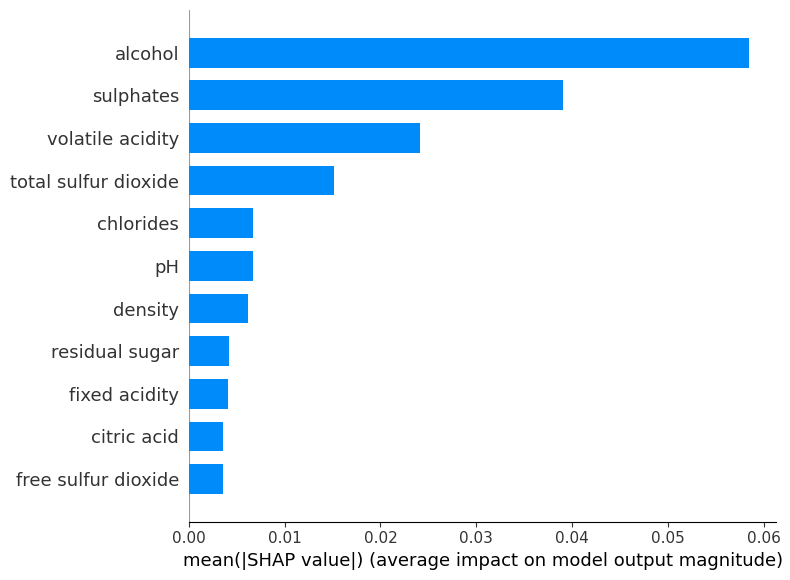

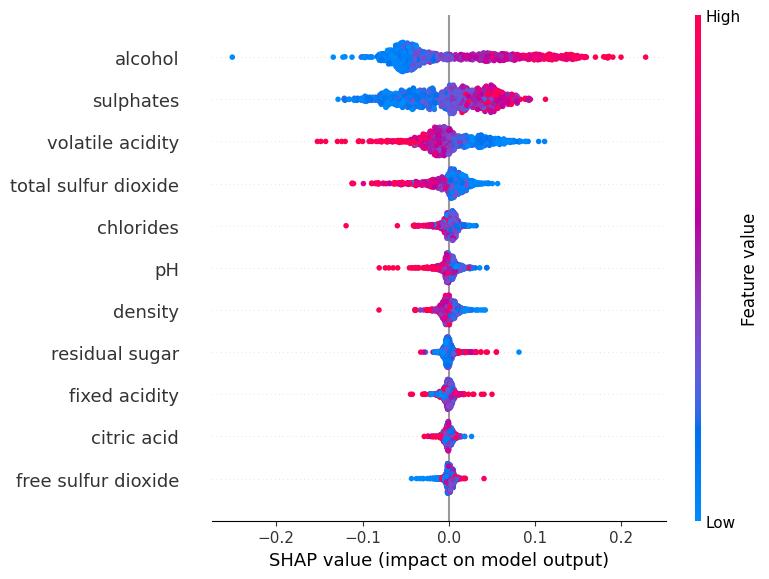

In [28]:
# compute shap values (time consuming)
import shap
explainer = shap.TreeExplainer(rfr)
shap_values = explainer.shap_values(x_train) # entire training set considered, could also use a random sample to fasten calculations

# bar chart of features importance
shap.summary_plot(shap_values, x_train, plot_type="bar")
plt.show()

# scatter/density plot for each feature
sp = shap.summary_plot(shap_values, x_train)
plt.show()

Interpretation:
- features/variables contributing the most to a high wine quality are sorted by decreasing order
- alcohol %, concentration in sulphates and volatile acidity are the three factors influencing wine quality the most
- in pink (blue) are represented high (low) variable values; e.g. a high alcohol % and low volatile acidity both contribute to high wine quality score

### 6. Conclusions

- the dataset has been split into x_train, y_train, yc_train, x_test, y_test, yc_test as asked, with a differentiation between continuous and categorical variables (see also the related discussion)
- basic plots/analyses such as scatter plots, correlation matrices, and overall box plot were'nt very informative, due to the nature of the data (many average wines, and discrete wine quality values)
- the most informative plots/analyses were: histograms per feature, with a very good/bad wine split, box plots per feature and wine quality score, the mutual information analysis
- some variables show a high redundancy level (variance inflation analysis), which is an attention point for the model selection/development/interpretation phases
- a random forest regression model has been fit with success, the accuracy measures on the test set being fairly good, and the features ranking is highly informative. Based on this model, it is possible to perform predictions and to forecast the good/bad wine category based on any relevant threshold (e.g. 0.2-0.8) applied to the normalized wine quality score
- the SHAP analysis better illustrates the level of impact of each feature on the predictions and how they contribute
- very good wines tend to be characterized by a clearly higher alcohol %, concentration of citric acid, a higher sulfates concentration, a much lower volatile acidity
- detailed interpretations can be found in the sections above